# EU Gas Storage Levels - Forecast

## Pt. 1: Data Request & Cleaning, Seasonal Historic Gas Storage Chart

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import requests
import plotly.graph_objects as go
from plotly.offline import plot

In [45]:
url = 'https://agsi.gie.eu/api?'
api = 'xxxxxxxxxx'  # redacted to protect from potential misuse - see README to be directed to API key registration
headers = {'x-key': api}

# params for url
query_dict = {
    'continent': 'eu',
 #   'country': 'de',
 #   'from': '2022-08-24',
 #   'to': '2022-01-01',
    'size': 300
}

### API Request and DataFrame Cleaning

In [46]:
# request data first to pull total number of pages (data['last_page']) during loop iteration
response = requests.get(url, params=query_dict, headers=headers)
data = response.json()

In [47]:
## Iterate over as many pages as params (query_dict) pulls, unless pages > 55
gas = []

for page in range(1, data['last_page']+1):
    # break if last page > 55
    if data['last_page'] > 55:
        print('---increase size param, limit range, or specify a date range to avoid API blacklist---')
        break
    
    print('----')
    last_page = page + 1

    url = f'https://agsi.gie.eu/api?&page={page}'
    response = requests.get(url, params=query_dict, headers=headers)
    print('total pages is', data['last_page'], 'currently requesting page', last_page - 1, 'and url: ', response.url)
    data = response.json()

    # append next page of data to list
    gas.extend(data['data'])

----
total pages is 15 currently requesting page 1 and url:  https://agsi.gie.eu/api?&page=1&continent=eu&size=300
----
total pages is 15 currently requesting page 2 and url:  https://agsi.gie.eu/api?&page=2&continent=eu&size=300
----
total pages is 15 currently requesting page 3 and url:  https://agsi.gie.eu/api?&page=3&continent=eu&size=300
----
total pages is 15 currently requesting page 4 and url:  https://agsi.gie.eu/api?&page=4&continent=eu&size=300
----
total pages is 15 currently requesting page 5 and url:  https://agsi.gie.eu/api?&page=5&continent=eu&size=300
----
total pages is 15 currently requesting page 6 and url:  https://agsi.gie.eu/api?&page=6&continent=eu&size=300
----
total pages is 15 currently requesting page 7 and url:  https://agsi.gie.eu/api?&page=7&continent=eu&size=300
----
total pages is 15 currently requesting page 8 and url:  https://agsi.gie.eu/api?&page=8&continent=eu&size=300
----
total pages is 15 currently requesting page 9 and url:  https://agsi.gie.eu

In [48]:
## Create and Clean DataFrame

df = pd.DataFrame(gas).sort_values(by='gasDayStart')
# drop unecessary columns
df = df.drop(['url', 'consumption', 'consumptionFull', 'info'], axis=1)
# convert all columns in cols from object to numeric
cols = df.columns.drop(['name', 'code', 'gasDayStart', 'status'])
df[cols] = df[cols].apply(pd.to_numeric)
# convert date to datetime type
df['gasDayStart'] = df['gasDayStart'].astype('datetime64[ns]')
# add net storage flow column
df['net storage flow'] = df['injection'] - df['withdrawal']
# add year and month-day columns for charting and analysis
df['year'] = df['gasDayStart'].dt.year
df['month_day'] = df['gasDayStart'].dt.strftime('%m-%d')

### Historic Gas Storage Seasonality Chart

In [88]:
# columns to get latest 10 years - used for sumary stats in pivot table
last_ten_years = slice(df['year'].iat[-1] - 9, df['year'].iat[-1])

# set up pivot table
pivot_full = pd.pivot_table(df, values='full', index=['month_day'], columns=['year'], aggfunc=np.sum)
# drop leap year
pivot_full = pivot_full.drop(pivot_full.index[59])
# add summary statistics columns
pivot_full['max'] = pivot_full.loc[:, last_ten_years].max(axis=1)
pivot_full['min'] = pivot_full.loc[:, last_ten_years].min(axis=1)
pivot_full['10 year avg'] = pivot_full.loc[:, last_ten_years].mean(axis=1)
pivot_full

year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,max,min,10 year avg
month_day,,,,,,,,,,,,,,,
01-01,71.32,78.50,72.34,69.34,73.02,69.80,63.18,64.05,69.83,88.02,73.69,53.76,88.02,53.76,69.703000
01-02,71.00,78.42,71.94,69.18,72.54,69.44,62.62,63.73,69.46,87.54,73.16,53.76,87.54,53.76,69.337000
01-03,70.50,78.11,71.54,69.00,72.13,69.04,61.90,63.36,68.89,87.14,72.60,53.61,87.14,53.61,68.921000
01-04,69.89,77.80,71.23,68.85,71.71,68.46,61.21,63.02,68.34,86.77,71.84,53.36,86.77,53.36,68.479000
01-05,69.32,77.50,70.96,68.71,71.13,67.89,60.38,62.68,67.93,86.37,71.02,52.99,86.37,52.99,68.006000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-27,80.69,73.47,69.81,77.72,71.12,65.59,65.46,70.86,89.36,76.27,53.78,NaN,89.36,53.78,71.107778
12-28,80.44,73.31,69.72,77.17,70.86,65.09,64.98,70.50,89.17,75.77,53.54,NaN,89.17,53.54,70.755556
12-29,80.17,73.15,69.60,76.48,70.56,64.53,64.55,70.28,88.95,75.25,53.44,NaN,88.95,53.44,70.404444


In [50]:
# establish figure, list of figure colors
full_eu_fig = go.Figure()
colors = ['#17becf','#e377c2','#ff7f0e','#2ca02c','darkblue','firebrick']
# build traces for 3 summary stats, fixing params to visualize max vs. min range band
# room for improvement: list month-day on x axis vs. currently showing day of year
full_eu_fig.add_trace(
    go.Scatter(
        x=np.arange(1,366),
        y=pivot_full['max'],
        fill=None,
        mode=None,
        line_color='lightgray',
        showlegend=False
        ))
full_eu_fig.add_trace(
    go.Scatter(
        x=np.arange(1,366),
        y=pivot_full['min'],
        fill='tonexty',
        mode=None,
        line_color='lightgray',
        showlegend=False))
full_eu_fig.add_trace(
    go.Scatter(x=np.arange(1,366),
    y=pivot_full['10 year avg'],
    name='10 year avg',
    line=dict(color='black', width=4, dash='dot')))
# build traces for each of past 5 years
for i in range(-8, -3):
    full_eu_fig.add_trace(
        go.Scatter(
            x=np.arange(1,366), 
            y=pivot_full.iloc[:,i], 
            name=pivot_full.columns[i], 
            line=dict(color=colors[i + 8], 
            width=4
            )))
# update layout, add axis labels
full_eu_fig.update_layout(
    title='EU gas storage - pct full as of: '+ data['gas_day'],
    xaxis_title='day of year',
    yaxis_title='pct. of storage filled',
    template='plotly_white')
plot(full_eu_fig)

'temp-plot.html'

In [ ]:
# ^^ see <output1_historic_gas_storage.png> in repo for chart output

## Pt. 2: Establish Linear Regression Model

In [51]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [52]:
# Need to first identify the most relevant independent variable(s) driving storage flows
    # then establish optimal model based on results

# Since it is known that weather is a large contributor to severity of gas flows,
    # we should first visualize and quantify this assumption.

### Read Degree Days csv, Clean and Merge DataFrame

In [53]:
## Read csv and Prep DataFrame

temp_df = pd.read_csv('tas_timeseries_monthly_cru_1901-2021_DEU.csv', skiprows=2)
# melt into long format (unpivot csv)
temp_df = temp_df.melt(id_vars=['Unnamed: 0'])
# rename cols
temp_df.columns = ['year', 'month', 'temperature']
# convert month to number
month_conv = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
temp_df['month'] = temp_df['month'].map(month_conv)
# combine cols to form date, resample to get last day of month
temp_df['date'] = pd.to_datetime(temp_df[['year', 'month']].assign(day=1))
temp_df = temp_df.drop(['year', 'month'], axis=1).set_index('date')
temp_df = temp_df.resample('M').sum().reset_index()
# convert temperature to F
temp_df['temperature'] = temp_df['temperature'] * (9/5) + 32
# add column to get degree days, with base 65 degrees
temp_df['degree_days'] = temp_df['temperature'] - 65

In [54]:
## Prep to merge relevant columns of multiple DataFrames

# create DataFrame of gasDayStart and storage flow from europe_gas_storage.py
storage_flow_df = df[['gasDayStart', 'net storage flow']]
# sum flows by month
storage_flow_df = storage_flow_df.set_index('gasDayStart').resample('M').sum().reset_index()
# merge df_storage_flow with dd on date
temp_df_merged = pd.merge(temp_df, storage_flow_df, how='inner', left_on='date', right_on='gasDayStart')
# show only relevant data for analysis: drop columns and set date as index
temp_df_merged = temp_df_merged.drop(['temperature', 'gasDayStart'], axis=1).set_index('date')

### Charting and Quantifying Correlation of Variables

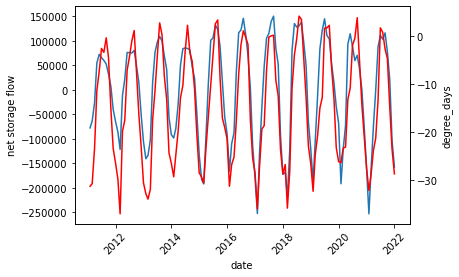

In [55]:
## Visualize and Quantify Potential Correlation

# plot EU net gas storage flows vs. degree days overtime
sns.lineplot(x='date', y='net storage flow', data=temp_df_merged)
plt.xticks(rotation=45)
ax2 = plt.twinx()
sns.lineplot(x='date', y='degree_days', color='r', data=temp_df_merged, ax=ax2)
plt.show()

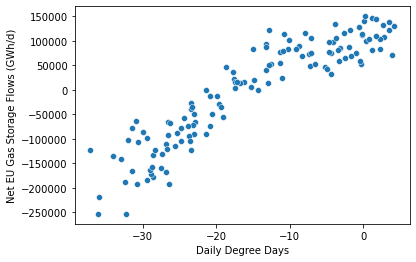

In [56]:
# scatterplot of net storage flows vs. degree days
sns.scatterplot(x='degree_days', y='net storage flow', data=temp_df_merged)
plt.xlabel('Daily Degree Days')
plt.ylabel('Net EU Gas Storage Flows (GWh/d)')
plt.show()

# visuals show that the lower the degree days (colder) the more gas is drawn from storage

In [57]:
# using Pearson correlation to quantify strength of relationship between two continuous variables 
print("Association between Daily Degree Days and Net EU Gas Storage Flows:")
print(pearsonr(temp_df_merged['degree_days'], temp_df_merged['net storage flow']))

Association between Daily Degree Days and Net EU Gas Storage Flows:
(0.9189681070822381, 2.199237843988015e-54)


In [58]:
# TAKEAWAY
    # strong correlation (92%) between explanatory and response variables exists
    # the association between degree days and net storage flows is statistically significant (p-value < 0.000)
    # Linear Regression model likely best-suited to forecast flows
        # based on results, degree days would be a great predictor for storage flows

### Running Linear Regression Model

In [59]:
# creating feature and target arrays
X_dd = temp_df_merged['degree_days'].values
y = temp_df_merged['net storage flow'].values
print(X_dd.shape, y.shape)

# reshape to make array 2D for scikitlearn compatibility
X_dd = X_dd.reshape(-1, 1)

(132,) (132,)


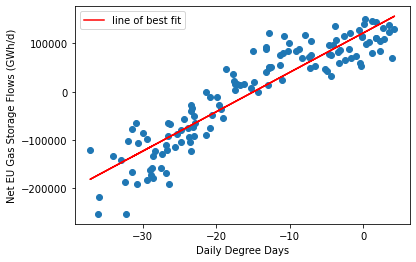

In [60]:
# instantiate regression model
reg = LinearRegression()
reg.fit(X_dd, y)
# predict storage flows using X_dd (y-axis for line of best fit)
predictions = reg.predict(X_dd)
# scatter plot plus reg line
plt.scatter(X_dd, y)
plt.plot(X_dd, predictions, color='r', label='line of best fit')
plt.legend()
plt.xlabel('Daily Degree Days')
plt.ylabel('Net EU Gas Storage Flows (GWh/d)')
plt.show()

In [61]:
# show slope and intercept of line of best fit
slope = (predictions[2] - predictions[1]) / (X_dd[2] - X_dd[1])
intercept = predictions[1] - (slope * X_dd[1])
print('slope: ', slope)
print('intercept: ', intercept)

slope:  [8174.38403544]
intercept:  [122012.47623794]


### Assessing LinReg Model Performance

In [62]:
r_squared = reg.score(X_dd, y)
print('R^2: {}'.format(r_squared))
# degree days explain 84% of the variance in storage flows

R^2: 0.8445023818343116


In [63]:
rmse = mean_squared_error(y, predictions, squared=False) # False to return sqrt of MSE
print('RMSE: {}'.format(rmse))
# model has average error of storage flows of 40,850 GWH/mo

RMSE: 40850.37329125997


In [64]:
# based on correlation, p-value, R^2 and RMSE output, Linear Regression is an appropriate model to predict storage levels

## Pt. 3: Forecasting Degree Days Using SARIMA

In [65]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset

### Identify Potential Seasonality to Establish Appropriate Time-Series Model

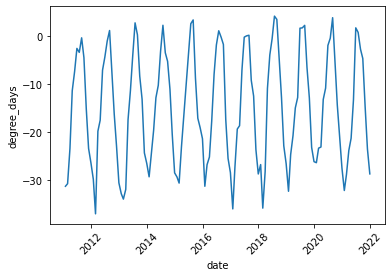

In [66]:
# chart degree days over time
sns.lineplot(x='date', y='degree_days', data=temp_df_merged)
plt.xticks(rotation=45)
plt.show()

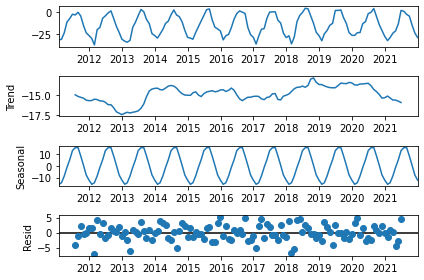

In [67]:
# Isolate and Analyze Trend, potential Seasonality, and Noise in degree days data
szn_dd = pd.DataFrame().assign(degree_days=temp_df_merged['degree_days'])
decompose_output = seasonal_decompose(szn_dd, model='additive', period=12)
decompose_output.plot()
plt.show()

In [68]:
# TREND:
    # no apparent trend in degree days
# SEASONALITY
    # is apparent in dataset, and statistically confirmed in Pt. 2: Establish Linear Regression Model
# RESIDUAL
    # what's left over after stripping out seasonality and trend
    # shows statistical noise, shows randomness and/or periodic anomalies

### SARIMA Modelling

In [ ]:
# establish, fit and predict
sarima = sm.tsa.statespace.SARIMAX(szn_dd['degree_days'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = sarima.fit()
szn_dd['forecast'] = results.predict(start=120, end=132, dynamic=False)

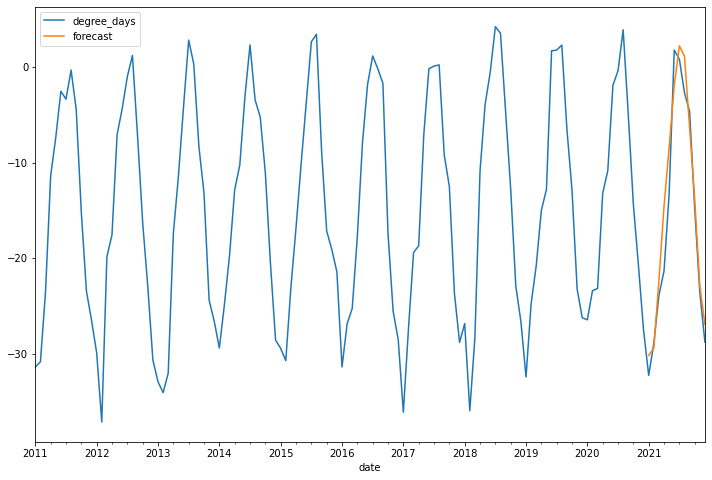

In [70]:
# chart results
szn_dd[['degree_days', 'forecast']].plot(figsize=(12,8))
plt.show()

In [71]:
# create NaN df of future dates and concat to original df to use for forecasting
pred_date = [szn_dd.index[-1] + DateOffset(months=x) for x in range(0,36)]
pred_date=pd.DataFrame(index=pred_date[1:], columns=szn_dd.columns)
szn_dd = pd.concat([szn_dd, pred_date])

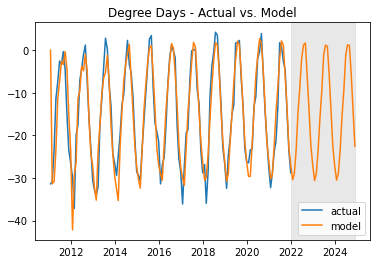

In [72]:
# plot model - prediction vs. actual and forecast
szn_dd['forecast'] = results.predict(start=0, end=190)
plt.plot(szn_dd['degree_days'], label='actual')
plt.plot(szn_dd['forecast'], label='model')
plt.axvspan(temp_df_merged.index[-1], szn_dd.index[-1], alpha=0.5, color='lightgrey')
plt.title('Degree Days - Actual vs. Model')
plt.legend()
plt.show()

In [73]:
# model returns forecasted values similar to history, making us confident in the model's preditive ability
# now that degree days has been forecasted,
    # time to feed it into the Linear Regression model (in Pt. 2) to estimate net storage flows

## Pt. 4: Forecasting EU Gas Storage Levels

In [74]:
# integrating outputs from Pt. 2 (Linear Regression Model) and Pt. 3 (SARIMA Model) 

### Merge and Prep DataFrames for Forecast 

In [75]:
# merge storage_flow_df with szn_dd
fcast_dd_flow = pd.merge(storage_flow_df, szn_dd.reset_index(), how='outer', left_on='gasDayStart', right_on='index')
fcast_dd_flow = fcast_dd_flow.drop(['gasDayStart'], axis=1)
fcast_dd_flow = fcast_dd_flow.set_index('index')
fcast_dd_flow[130:145]

,net storage flow,degree_days,forecast
index,,,
2021-11-30,-103345.71,-23.586,-22.883052
2021-12-31,-157826.88,-28.788,-26.951067
2022-01-31,-178255.71,NaN,-30.409638
2022-02-28,-96375.84,NaN,-29.092996
2022-03-31,-25119.06,NaN,-23.349904
2022-04-30,74024.66,NaN,-14.653054
2022-05-31,153001.75,NaN,-8.658036
2022-06-30,121825.04,NaN,-1.980832
2022-07-31,124899.33,NaN,1.232766


### Forecasting Net Storage Flow

In [76]:
# slope and intercept of line of best fit
slope = (predictions[2] - predictions[1]) / (X_dd[2] - X_dd[1])
intercept = predictions[1] - (slope * X_dd[1])
print('slope: ', slope)
print('intercept: ', intercept)

slope:  [8174.38403544]
intercept:  [122012.47623794]


In [77]:
# interpolate linear regression output with forecasted degree days to get forecasted storage flows
fcast_dd_flow['storage flow forecast'] = fcast_dd_flow['forecast'] * slope + intercept

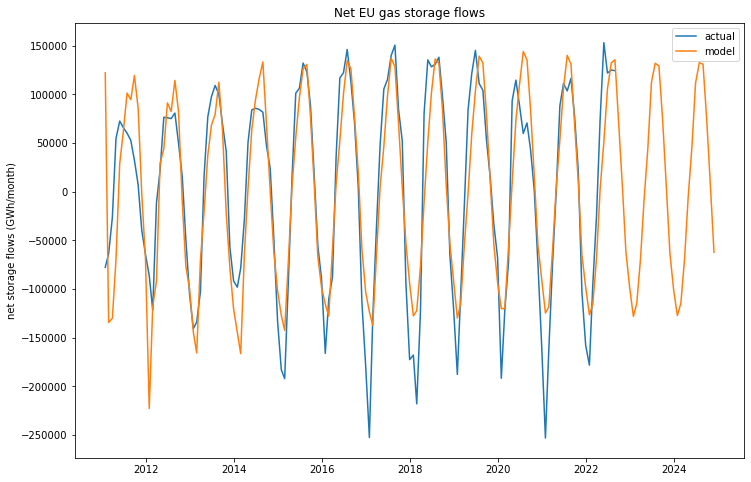

In [78]:
# chart actual vs. modeled storage flows
plt.figure(figsize=(12,8))
plt.plot(fcast_dd_flow.index, fcast_dd_flow['net storage flow'], label='actual')
plt.plot(fcast_dd_flow.index, fcast_dd_flow['storage flow forecast'], label='model')
plt.title('Net EU gas storage flows')
plt.ylabel('net storage flows (GWh/month)')
plt.legend()
plt.show()

### Forecasting Storage Levels

In [79]:
## Create df with metrics needed to forecast Storage Levels (abs and rel)

# pull relevant cols from original df
gas_storage = df[['gasDayStart', 'gasInStorage', 'workingGasVolume']].set_index('gasDayStart')
# get monthly storage levels and capacity - last day of month value
gas_storage = gas_storage.groupby([gas_storage.index.year, gas_storage.index.month]).tail(1)

# merge historic gas storage
fcast_gas_storage = gas_storage.join(fcast_dd_flow, how='outer')
# drop rows where storage flow forecast is NaN (current date is included in the merged df - need index of just EoM)
fcast_gas_storage = fcast_gas_storage.dropna(subset=['storage flow forecast'])

In [ ]:
# create empty column
fcast_gas_storage['gasInStorage forecast'] = np.nan
# start forecast by adding most recent historic value to forecasted numbers
fcast_gas_storage['gasInStorage forecast'].iloc[len(storage_flow_df)-2] = (fcast_gas_storage['gasInStorage'].iloc[len(storage_flow_df)-2])
# remaining forecast uses prior month's 'gasInStorage forecast' and adds current month 'storage flow forecast'
for i in range(len(storage_flow_df)-1, len(fcast_gas_storage)):
    fcast_gas_storage['gasInStorage forecast'].iloc[i] = (
        fcast_gas_storage['gasInStorage forecast'].iloc[i-1] + 
        fcast_gas_storage['storage flow forecast'].iloc[i] /
        1000)

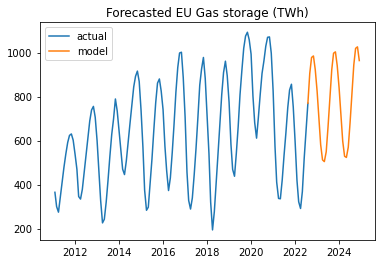

In [81]:
# chart history and forecast
plt.plot(fcast_gas_storage['gasInStorage'], label='actual')
plt.plot(fcast_gas_storage['gasInStorage forecast'], label='model')
plt.title('Forecasted EU Gas storage (TWh)')
plt.legend()
plt.show()

### Seasonal Charting: Forecasting % of Gas Storage Full

In [82]:
# extrapolate workingGasVolume (NaN rows) with most recent value
fcast_gas_storage['workingGasVolume'] = fcast_gas_storage['workingGasVolume'].fillna(method='ffill')
# add pct full columns - history and forecast
fcast_gas_storage['pct full hist'] = fcast_gas_storage['gasInStorage'] / fcast_gas_storage['workingGasVolume']
fcast_gas_storage['pct full fcast'] = fcast_gas_storage['gasInStorage forecast'] / fcast_gas_storage['workingGasVolume']
fcast_gas_storage['pct full'] = fcast_gas_storage['pct full hist'].fillna(fcast_gas_storage['pct full fcast'])

In [83]:
# columns to get latest 10 years
last_ten_years = slice(df['year'].iat[-1] - 9, df['year'].iat[-1])
# create month and year columns to pivot on
fcast_gas_storage['month'] = fcast_gas_storage.index.month 
fcast_gas_storage['year'] = fcast_gas_storage.index.year

In [87]:
# set up pivot table
pivot_fcast = pd.pivot_table(fcast_gas_storage, values='pct full', index=['month'], columns=['year'], aggfunc=np.sum)
# add summary statistics columns
pivot_fcast['max'] = pivot_fcast.loc[:, last_ten_years].max(axis=1)
pivot_fcast['min'] = pivot_fcast.loc[:, last_ten_years].min(axis=1)
pivot_fcast['10 year avg'] = pivot_fcast.loc[:, last_ten_years].mean(axis=1)
pivot_fcast

year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,max,min,10 year avg
month,,,,,,,,,,,,,,,,,
1,0.589382,0.664287,0.555355,0.588434,0.554701,0.543245,0.410341,0.488548,0.525999,0.713671,0.515148,0.376418,0.628218,0.642371,0.713671,0.376418,0.527186
2,0.484857,0.488856,0.394986,0.504647,0.365508,0.439369,0.294670,0.289670,0.423535,0.606183,0.368579,0.289792,0.524458,0.538902,0.606183,0.289670,0.397694
3,0.441238,0.472539,0.272301,0.478382,0.276759,0.352014,0.260532,0.183495,0.413091,0.541743,0.300566,0.262861,0.462000,0.476936,0.541743,0.183495,0.334174
4,0.516374,0.463505,0.288597,0.528886,0.289648,0.383413,0.305833,0.251339,0.491054,0.626549,0.300402,0.333700,0.454952,0.472060,0.626549,0.251339,0.379942
5,0.623924,0.556580,0.373752,0.611400,0.393422,0.485432,0.401534,0.373469,0.601854,0.723176,0.376944,0.474573,0.495051,0.513765,0.723176,0.373469,0.481556
6,0.721532,0.650652,0.484058,0.699227,0.494425,0.599952,0.507594,0.487633,0.730418,0.805317,0.475533,0.583166,0.596250,0.614287,0.805317,0.475533,0.586732
7,0.811738,0.740331,0.611610,0.784281,0.618936,0.730292,0.633056,0.606299,0.826513,0.853194,0.569616,0.694536,0.715229,0.733728,0.853194,0.569616,0.692833
8,0.890969,0.837633,0.727573,0.868001,0.736645,0.829959,0.767017,0.732289,0.918270,0.911476,0.674093,0.816826,0.831750,0.851787,0.918270,0.674093,0.798215
9,0.939512,0.898382,0.807787,0.913641,0.821118,0.898008,0.840687,0.821893,0.966809,0.947036,0.747051,0.882128,0.899497,0.919490,0.966809,0.747051,0.864616


In [85]:
# establish figure, list of figure colors
fcast_eu_fig = go.Figure()
colors = ['#17becf','#e377c2','#ff7f0e','#2ca02c','darkblue','firebrick']
# build traces for 3 summary stats, fixing params to visualize max vs. min range band
# room for improvement: list month-day on x axis vs. currently showing day of year
fcast_eu_fig.add_trace(
    go.Scatter(
        x=pivot_fcast.index,
        y=pivot_fcast['max'],
        fill=None,
        mode=None,
        line_color='lightgray',
        showlegend=False
        ))
fcast_eu_fig.add_trace(
    go.Scatter(
        x=pivot_fcast.index,
        y=pivot_fcast['min'],
        fill='tonexty',
        mode=None,
        line_color='lightgray',
        showlegend=False))
fcast_eu_fig.add_trace(
    go.Scatter(x=pivot_fcast.index,
    y=pivot_fcast['10 year avg'],
    name='10 year avg',
    line=dict(color='black', width=4, dash='dot')))
# build traces for each
for i in range(-6, -3):
    fcast_eu_fig.add_trace(
        go.Scatter(
            x=pivot_fcast.index, 
            y=pivot_fcast.iloc[:,i], 
            name=pivot_fcast.columns[i], 
            line=dict(color=colors[i + 8], 
            width=4
            )))
# update layout, add title and axis labels
fcast_eu_fig.update_layout(
    title='EU gas storage 10yr range - pct full - forecast begins ' + str(gas_storage.index[-1].month) + '-' + str(gas_storage.index[-1].year),
    xaxis_title='month',
    yaxis_title='pct. of storage filled',
    template='plotly_white')
plot(fcast_eu_fig)

'temp-plot.html'

In [ ]:
# ^^ see <output2_forecast_gas_storage.png> in repo for chart output